In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy.random as rnd
from PIL import Image

# plt.rcParams['image.cmap'] = 'cubehelix'
plt.rcParams['image.cmap'] = 'afmhot'

In [54]:
def random_antenna_pos(x_lims = 1000, y_lims =1000):
    return rnd.random_sample(2)*np.array([x_lims,y_lims]) - np.array([x_lims, y_lims])/2

def radial_antenna_arr(n_antenna= 3, x_lims=1000, y_lims=1000, r=300):
    return np.array([[np.cos(angle)*r, np.sin(angle)*r] for angle in [2*np.pi/n_antenna*i for i in range(n_antenna)]])

def y_antenna_arr(n_antenna=5, r=500, alpha=0):
    step = r/n_antenna
    return np.array([ [np.array([(i+1)*step*np.cos(angle/180*np.pi), (i+1)*step*np.sin(angle/180*np.pi)]) for i in range(n_antenna)] for angle in [alpha, alpha+120, alpha+240] ]).reshape((3*n_antenna,2))

def random_antenna_arr(n_antenna=3, x_lims=1000, y_lims=1000):
    return np.array([random_antenna_pos(x_lims, y_lims) for i in range(n_antenna)])

def get_baselines(array):
    # Get the baseline for every combination of antennas i-j.
    # Remove the i=j baselines: np.delete(array, list, axis=0) -> delete the rows listed on 'list' from array 'array'. 
    return np.delete(np.array([antenna_i-antenna_j for antenna_i in array for antenna_j in array]), [(len(array)+1)*n for n in range(len(array))], 0)

def uv_time_int(baselines, array_latitud=35/180*np.pi,source_declination=35/180*np.pi, track_time=8, delta_t=5/60, t_0=-2):
    # visibility rotation matrix
    def M(h):
        return np.array([[np.sin(h/12*np.pi), -np.cos(h/12*np.pi), 0],
                        [-np.sin(source_declination)*np.cos(h/12*np.pi), -np.sin(source_declination)*np.sin(h/12*np.pi), np.cos(source_declination)]])
    # Baseline transformation from (north,east,elev=0) to (x,y,z)
    B = np.array([[-np.sin(array_latitud) , 0],
            [0 , -1],
            [np.cos(array_latitud) , 0]])

    n_samples = int(track_time/delta_t)
    track = []
    # Swap baselines xy
    baselines_sw = baselines[:,[1, 0]]
    for t in range(n_samples):
        track.append(baselines_sw.dot(B.T).dot(M(t_0+t*delta_t).T))
    # Reshape list of arrays into one long list and swap (u,v)
    return np.array(track).reshape((-1,2))#[:,[1, 0]]


def get_uv_plane(baseline, uv_dim=128):
    # Count number of samples per uv grid
    x_lim=np.max(np.absolute(baseline))#*1.1
    y_lim=x_lim
    uv_plane, _, _ = np.histogram2d(baseline[:,0],baseline[:,1],bins=uv_dim, range=[[-x_lim,x_lim],[-y_lim,y_lim]])
    return np.fliplr(uv_plane.T)#/np.sum(uv_plane, axis=(0,1))

def get_uv_mask(uv_plane):
    uv_plane_mask = uv_plane.copy()
    uv_plane_mask[np.where(uv_plane>0)] = 1
    return uv_plane_mask

def get_beam(uv_mask):
    return np.abs(np.fft.ifft2(uv_mask))

def plot_beam(beam, pRng = (-0.1, 0.5)):
    zMin = np.nanmin(beam)
    zMax = np.nanmax(beam)
    zRng = zMin - zMax
    zMin -= zRng * pRng[0]
    zMax += zRng * pRng[1]
    plt.imshow(np.fft.ifftshift(beam), vmin=zMin, vmax=zMax)
    plt.colorbar()
    plt.show()

def plot_antenna_arr(array):
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(array[:,0], array[:,1],s=20, c='gray')
    for i, txt in enumerate(range(1,len(array)+1,1)):
        plt.annotate(txt, (array[i,0], array[i,1]))
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        x_lim=max(abs(array[:,0]))*1.1
        y_lim=max(abs(array[:,1]))*1.1
        plt.xlim(-x_lim, x_lim)
        plt.ylim(-y_lim, y_lim)
    plt.show()

def plot_uv_plane(visibilities, n_baselines=None):
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(visibilities[:,0], visibilities[:,1],s=0.4, c='gray')
    if n_baselines is not None:
        delta = int(visibilities.shape[0]/2)
        plt.scatter(visibilities[delta:delta+n_baselines,0], visibilities[delta:delta+n_baselines,1], s=2,c='k')
    plt.xlabel(r'u x $\lambda$ [m]')
    plt.ylabel(r'v x $\lambda$ [m]')
    plt.xlim([np.min(visibilities), np.max(visibilities)])
    plt.ylim([np.min(visibilities), np.max(visibilities)])
    plt.show()

def load_sky_model(path):
    return np.array(Image.open(path).convert("L"))

def plot_sky(image):
    plt.imshow(image)
    plt.show()
    print('Image shape:', image.shape)
    print('Image range: ({},{})'.format(np.min(image), np.max(image)))

def get_sky_uv(sky):
    return np.fft.fft2(sky)

def plot_sky_uv(sky_uv):
    plt.imshow(np.abs(np.fft.fftshift(sky_uv)), norm=matplotlib.colors.LogNorm())
    plt.show()

def get_obs_uv(sky_uv, mask):
    return np.fft.fftshift(sky_uv).copy()*mask

def plot_sampled_sky(sky_uv):
    plt.imshow(np.abs(sky_uv)+1e-3, norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.show()

def get_obs_sky(obs_uv):
    return np.fft.ifft2(np.fft.ifftshift(obs_uv))
    
# def plot_beam(uv_plane, pad = 10, crop=32):
#     crop = int(crop/2)
#     uv_pad = np.pad(uv_plane, ((pad,pad),(pad,pad)), 'constant')
#     beam_full = np.absolute(np.fft.fft2(uv_pad))
#     beam_crop = np.delete(np.delete(beam_full,range(crop,len(beam_full)-crop),1), range(crop,len(beam_full)-crop), 0)
#     plt.imshow(10*np.log(np.fft.fftshift(beam_crop)),cmap='jet')
#     # plt.imshow(np.fft.fftshift(beam_crop),norm='log',cmap='jet')
#     plt.colorbar()
#     plt.show()

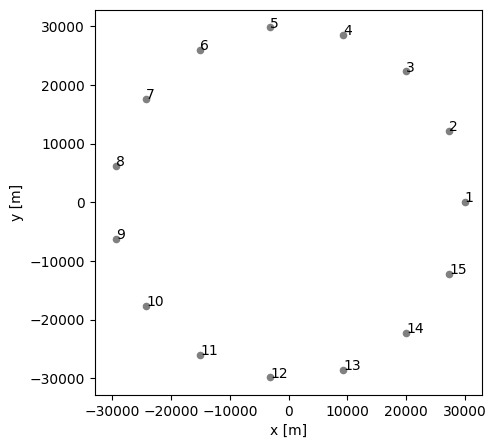

In [55]:
# Antenna parameters
x_lim = 30000
y_lim = 30000
n_antenna = 3*5
n_baselines = n_antenna*(n_antenna-1)
radius = 30000
alpha = 120
#arr = random_antenna_arr(n_antenna, x_lim, y_lim)
arr = radial_antenna_arr(n_antenna, x_lim, y_lim,radius)
# arr = y_antenna_arr(int(n_antenna/3), radius, alpha)
plot_antenna_arr(arr)

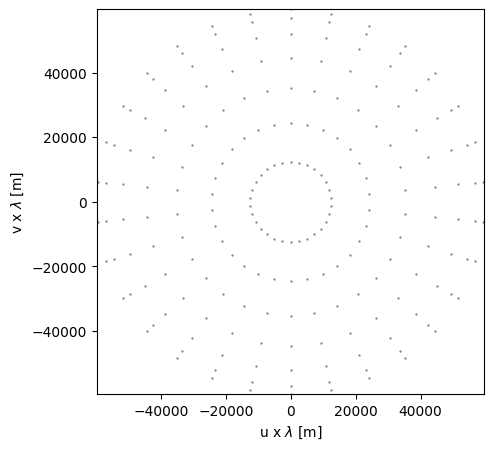

In [56]:
# Get baselines from array and plot
base_arr = get_baselines(arr)
plot_uv_plane(base_arr)

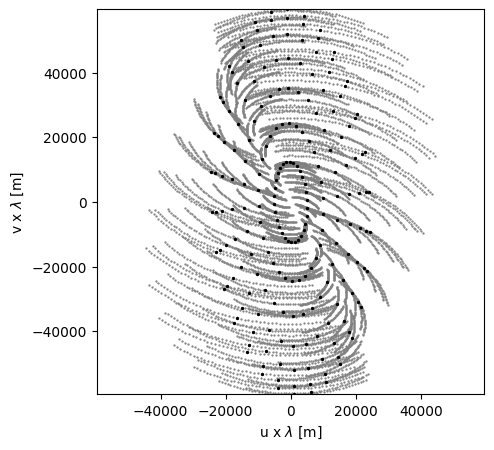

In [57]:
# Source tracking parameters
source_decl = 47/180*np.pi
array_lat = 19.1/180*np.pi
track_time = 4
delta_t = 5/60
t_0 = 3

# Get time integrated uv plane
track = uv_time_int(base_arr, array_lat, source_decl, track_time, delta_t, t_0)
plot_uv_plane(track, n_baselines)

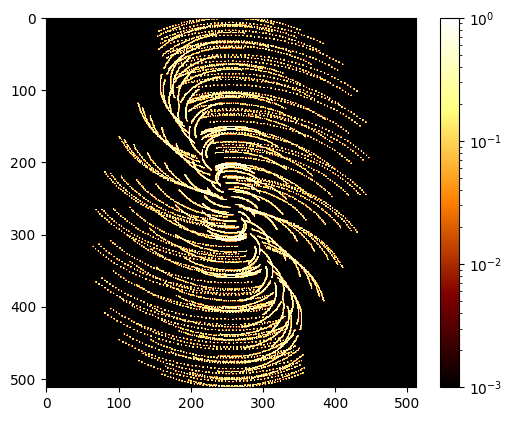

In [58]:
uv_dim = 512
uv_plane = get_uv_plane(track,uv_dim)
uv_plane_mask = get_uv_mask(uv_plane)
plot_sampled_sky(uv_plane_mask)

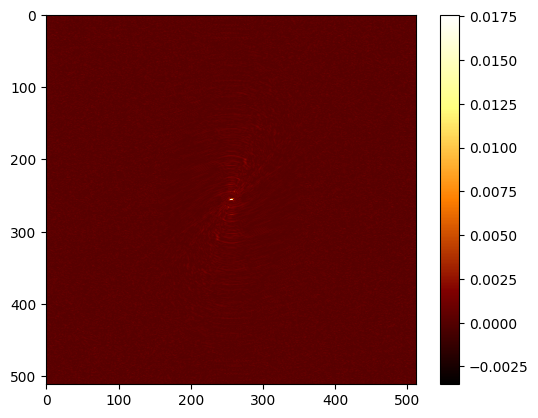

In [59]:
beam = get_beam(uv_plane_mask)
plot_beam(beam)


# Load Sky Model

In [60]:
sky_models_folder = '../sky_models/'
sky_model = 'crux.png'
sky_model_path = sky_models_folder + sky_model

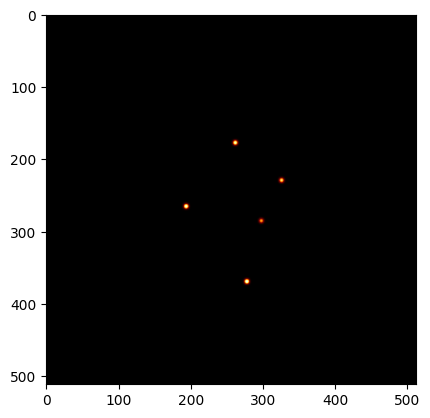

Image shape: (512, 512)
Image range: (0,250)


In [61]:
sky = load_sky_model(sky_model_path)
plot_sky(sky)

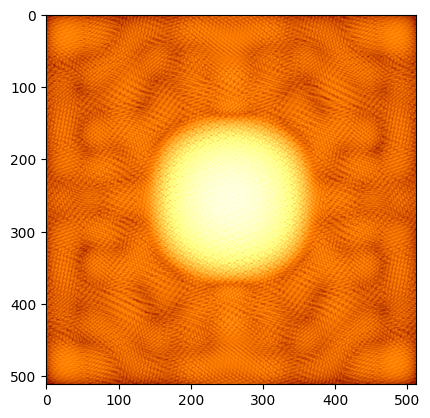

In [62]:
# pixScaleImg_asec = 5
# nX, nY = sky.shape
sky_uv = get_sky_uv(sky)
# modelFFTarr = np.fft.fftshift(modelFFTarr)
# pixScaleImg_lam = np.radians(pixScaleImg_asec/3600.0)
# fftScale_lam = 1.0/pixScaleImg_lam
# pixScaleFFTX_lam = 2.0*fftScale_lam/nX
# pixScaleFFTY_lam = 2.0*fftScale_lam/nY
plot_sky_uv(sky_uv)


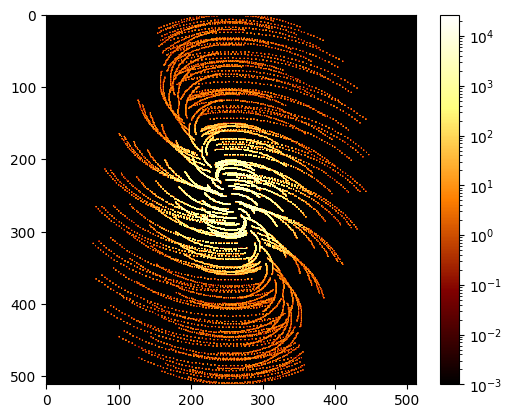

In [63]:
obs_uv = get_obs_uv(sky_uv,uv_plane_mask)
plot_sampled_sky(obs_uv)

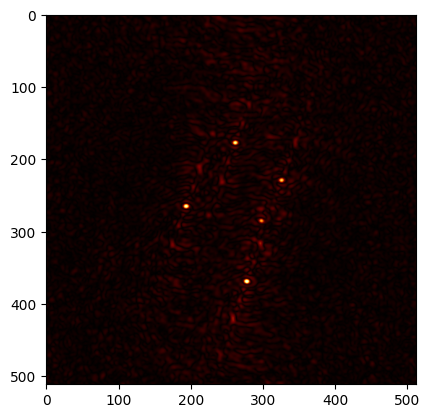

Image shape: (512, 512)
Image range: (0.0005773969069830847,31.935529965845017)


In [64]:
obs_sky = get_obs_sky(obs_uv)
plot_sky(np.abs(obs_sky))

# Padding - Work in progress...

In [65]:
pad = 0
sky_pad = np.pad(sky, ((pad,pad),(pad,pad)), 'constant')
sky_uv = (np.fft.fft2(sky_pad))
crop = 10000#int(uv_dim/2)
sky_uv_crop = np.delete(np.delete(sky_uv,range(crop,len(sky_uv)-crop),1), range(crop,len(sky_uv)-crop), 0)
sky_uv_crop = (np.fft.fftshift(sky_uv_crop))

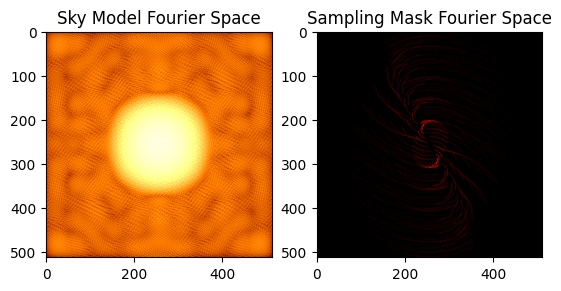

In [66]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.absolute(sky_uv_crop),norm=matplotlib.colors.LogNorm())
ax[0].set_title('Sky Model Fourier Space')
ax[1].imshow(uv_plane)
ax[1].set_title('Sampling Mask Fourier Space')
plt.show()

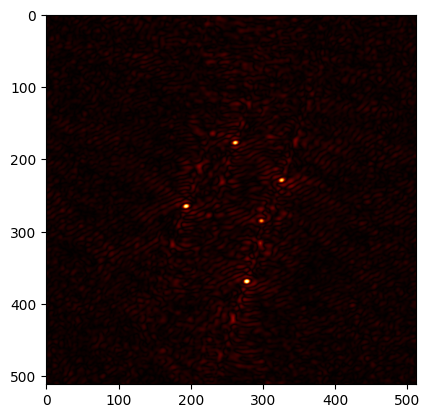

Image shape: (512, 512)
Image range: (0.006027599956104484,41.31957463314617)


In [67]:
# Reconstruct sky
uv_sampled = np.multiply(sky_uv_crop, uv_plane)
sky_recovered = np.absolute(np.fft.ifft2((uv_sampled)))

plt.imshow(sky_recovered)
plt.show()
print('Image shape:', sky_recovered.shape)
print('Image range: ({},{})'.format(np.min(sky_recovered), np.max(sky_recovered)))

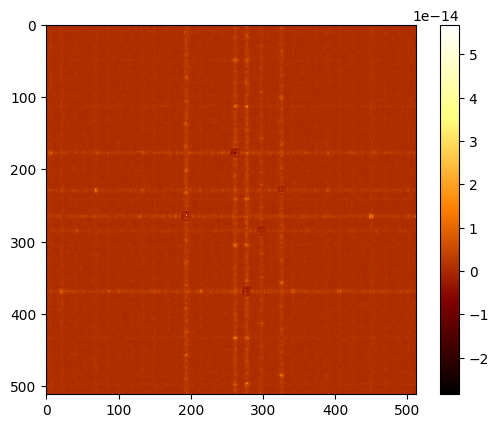

In [69]:
plt.imshow(np.absolute(np.fft.ifft2((sky_uv))) - sky)
plt.colorbar()